# DATA EXPLORATION of CIFAR-100

In [ ]:
import torchvision
import torch
import random
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from collections import Counter
import matplotlib.pyplot as plt
from collections import defaultdict
import os
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2



# Seeds for reproducibility
seed = 999
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
""" DATAEST DOWNLOAD """

ROOT = './data'
#BATCH_SIZE=32
BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count()

tot_train_data = torchvision.datasets.CIFAR100(root=ROOT, train=True, download=True, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.CIFAR100(root=ROOT, train=False, download=True, transform=torchvision.transforms.ToTensor())

tot_train_loader = DataLoader(tot_train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

100%|██████████| 169M/169M [00:13<00:00, 12.5MB/s]


In [ ]:
""" DATASET INFO """

print(f" The tot_train_data is:\n{tot_train_data}\n")
print(f" The test_data is:\n{test_data}\n")

image, label = tot_train_data[0]
print(f"Shape imagine:{image.shape}\n")

 The tot_train_data is:
Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

 The test_data is:
Dataset CIFAR100
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

Shape imagine:torch.Size([3, 32, 32])



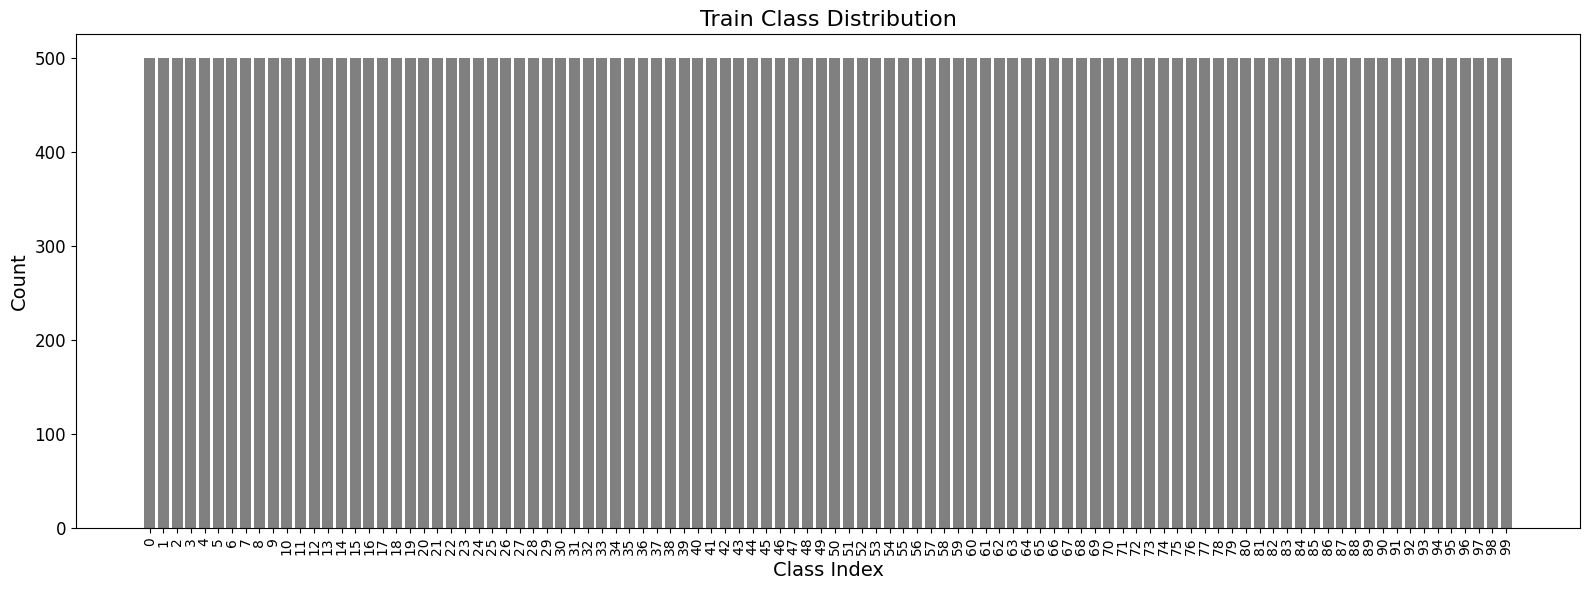

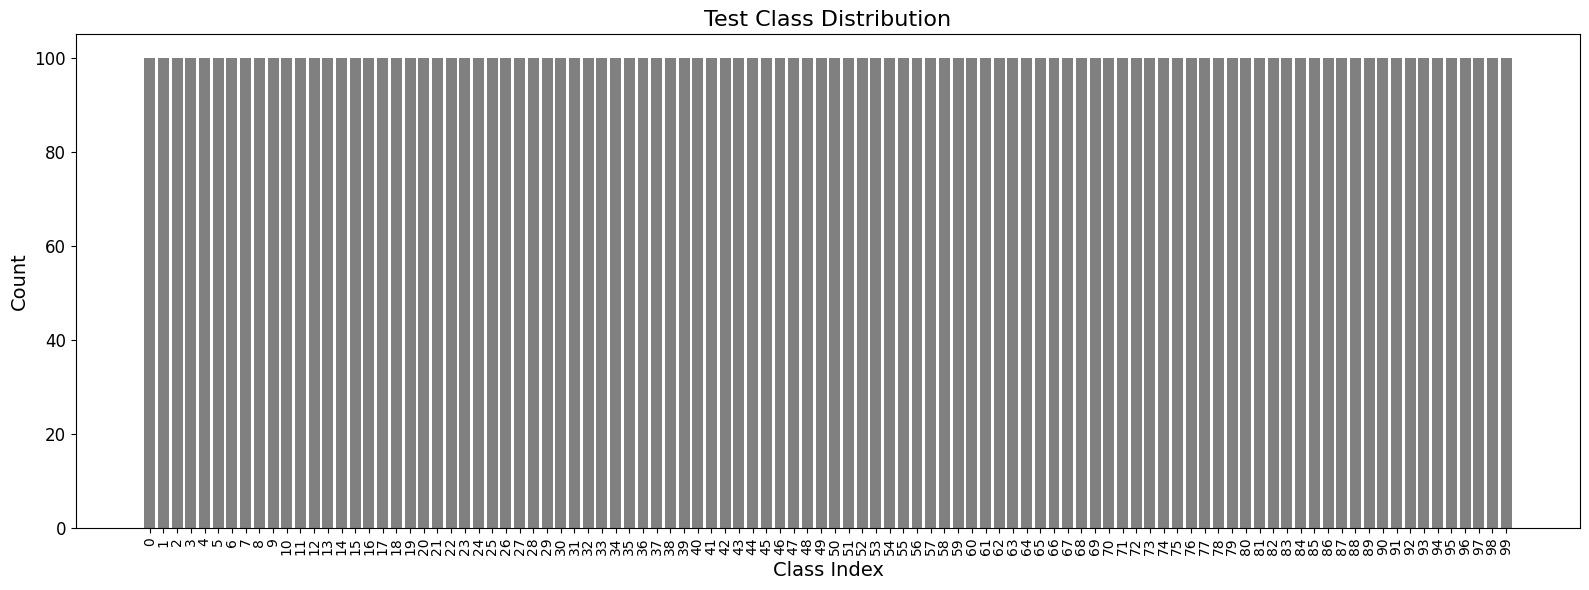

In [ ]:
""" CLASS DISTRIBUTION """

def plot_class_distribution(dataset, title='Class Distribution'):
    """
    Visualizes the frequency of each class in a dataset by plotting a bar chart of class counts.
    """
    labels = [label for _, label in dataset]
    counter = Counter(labels)

    plt.figure(figsize=(16, 6))
    bars = plt.bar(counter.keys(), counter.values(), color='gray')

    plt.title(title, fontsize=16)
    plt.xlabel("Class Index", fontsize=14)
    plt.ylabel("Count", fontsize=14)

    plt.xticks(list(counter.keys()), fontsize=10, rotation=90)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()


plot_class_distribution(tot_train_data, title='Train Class Distribution')
plot_class_distribution(test_data, title='Test Class Distribution')

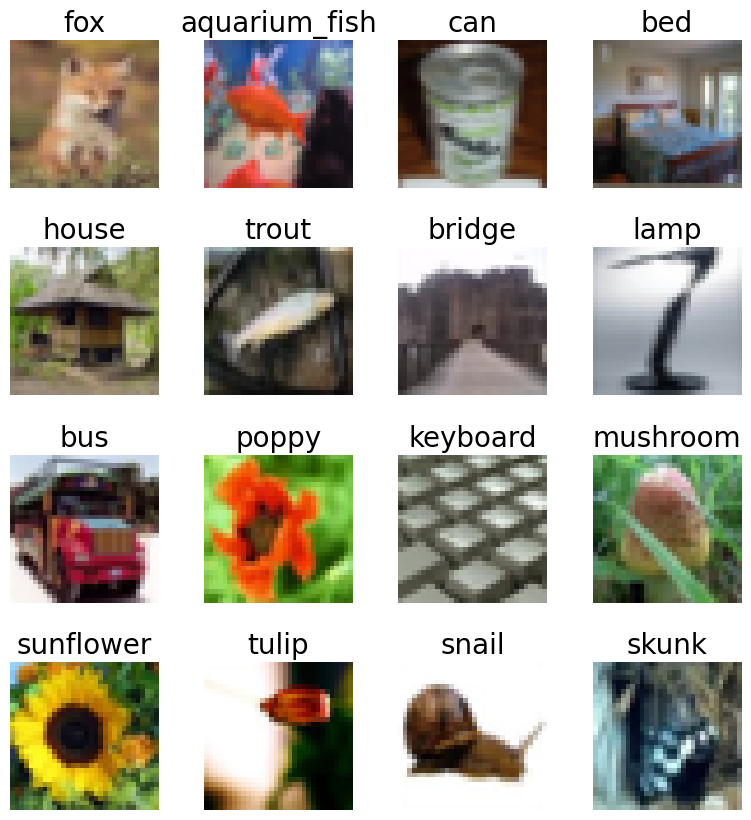

In [ ]:
""" IMAGE and LABEL PRINT """

def plot_images_with_labels(dataset, n_images=16):
    """
    Randomly samples and displays a specified number of images from a dataset along with their class labels in a grid layout.
    """
    rows = int(np.sqrt(n_images))
    cols = int(np.ceil(n_images / rows))

    torch.manual_seed(999)
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5),
                            gridspec_kw={'hspace': 0.4, 'wspace': 0.01})

    axs = axs.flatten()  # make axs linearly iterable

    for i in range(n_images):
        idx = torch.randint(0, len(dataset), size=(1,)).item()
        img, label = dataset[idx]
        img = img.permute(1, 2, 0).numpy()

        axs[i].imshow(img)
        axs[i].set_title(dataset.classes[label], fontsize=20)
        axs[i].axis('off')

    # Hides the extra axes if n_images < rows * cols.
    for j in range(n_images, len(axs)):
        axs[j].axis('off')
    plt.show()

N_IMAGES = 16
plot_images_with_labels(tot_train_data, n_images=N_IMAGES)

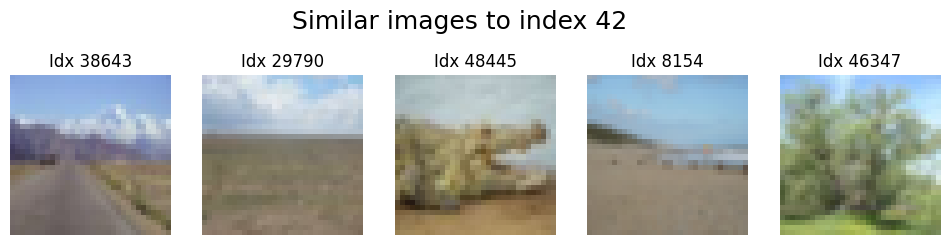

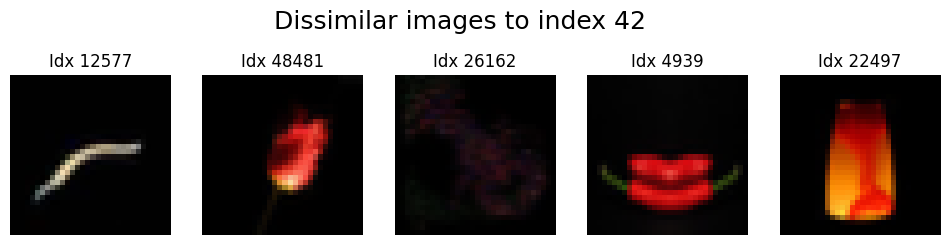

In [ ]:
""" SIMILARITY and DISSIMILARITY of the IMMAGES (considering tot_train_data)"""
def image_to_feature(img_tensor):
    """
    Flatten or use the mean to obtain simplified features
    """
    return img_tensor.view(-1).numpy()


def show_similar_images(dataset, reference_idx=0, top_k=5, mode="similar"):
    """
    Displays the most similar or dissimilar images to the one with index `reference_idx`
    """
    reference_img, _ = dataset[reference_idx]
    reference_vec = image_to_feature(reference_img)

    distances = []
    for i in range(len(dataset)):
        if i == reference_idx:
            continue
        img, _ = dataset[i]
        vec = image_to_feature(img)
        dist = np.linalg.norm(reference_vec - vec)
        distances.append((dist, i))

    # Sort distances
    distances.sort(reverse=(mode == "dissimilar"))  # dissimilar = large distances

    # Display images
    fig = plt.figure(figsize=(12, 3))
    plt.suptitle(f"{mode.title()} images to index {reference_idx}", fontsize=18)

    for i in range(top_k):
        _, idx = distances[i]
        img, label = dataset[idx]
        img = img.permute(1, 2, 0)
        ax = fig.add_subplot(1, top_k, i + 1)
        ax.imshow(img)
        ax.set_title(f"Idx {idx}")
        ax.axis('off')
    plt.show()


# Show the 5 most similar images to the one with index 42
show_similar_images(tot_train_data, reference_idx=42, top_k=5, mode="similar")
# Show the 5 most dissimilar ones
show_similar_images(tot_train_data, reference_idx=42, top_k=5, mode="dissimilar")

Image extraction: 100%|██████████| 50000/50000 [00:03<00:00, 15665.42it/s]


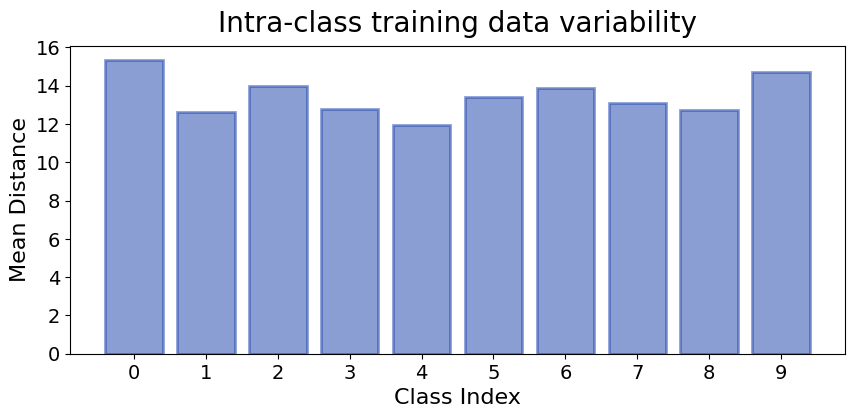

Image extraction: 100%|██████████| 10000/10000 [00:00<00:00, 16032.51it/s]


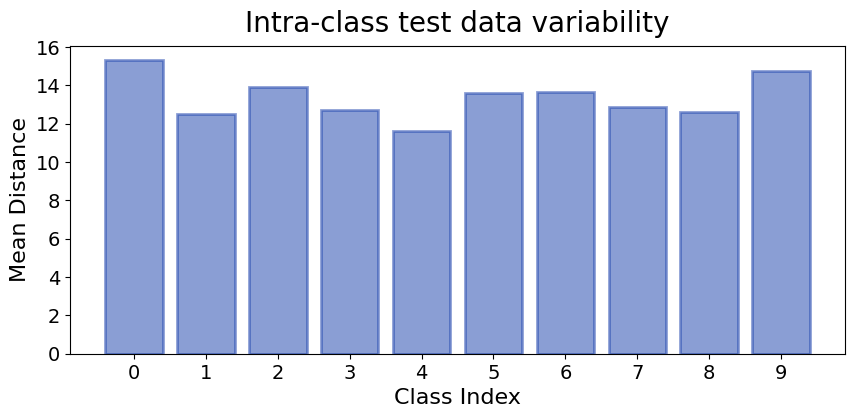

In [ ]:
""" COMPUTE INTRA-CLASS VARIABILITY """
def compute_intra_class_variability(dataset, num_classes=10, samples_per_class=100):
    """
    Computes the intra-class variability for the first `num_classes` in the dataset.
    """
    class_vectors = defaultdict(list)

    # Step 1: collect image vectors (flatten).
    for img, label in tqdm(dataset, desc="Image extraction"):
        if label < num_classes and len(class_vectors[label]) < samples_per_class:
            vec = img.view(-1).numpy()
            class_vectors[label].append(vec)

    intra_variability = {}

    # Step 2: for each class, calculate the average distance from the centroid.
    for cls, vectors in class_vectors.items():
        vectors = np.array(vectors)
        centroid = vectors.mean(axis=0)
        distances = np.linalg.norm(vectors - centroid, axis=1)
        intra_variability[cls] = distances.mean()
    return intra_variability

### Variability of the WHOLE training dataset
variability_train = compute_intra_class_variability(tot_train_data, num_classes=10, samples_per_class=500)

edge_color = '#173EAA'
face_color = '#173EAA'
alpha_value = 0.5

# Order and print
sorted_variability = dict(sorted(variability_train.items()))
plt.figure(figsize=(10, 4))
plt.bar(sorted_variability.keys(), sorted_variability.values(), edgecolor=edge_color, facecolor=face_color, alpha=alpha_value, linewidth=2)
plt.title("Intra-class training data variability", fontsize=20, pad=10)
plt.xlabel("Class Index", fontsize=16)
plt.ylabel("Mean Distance", fontsize=16)
plt.xticks(ticks=list(range(10)), fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Variability of the test dataset
variability_test = compute_intra_class_variability(test_data, num_classes=10, samples_per_class=100)

# Order and print
sorted_variability = dict(sorted(variability_test.items()))
plt.figure(figsize=(10, 4))
plt.bar(sorted_variability.keys(), sorted_variability.values(), edgecolor=edge_color, facecolor=face_color, alpha=alpha_value, linewidth=2)
plt.title("Intra-class test data variability", fontsize=20, pad=10)
plt.xlabel("Class Index", fontsize=16)
plt.ylabel("Mean Distance", fontsize=16)
plt.xticks(ticks=list(range(10)), fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Using Mahalanobis distance threshold: 4.033
Global Outlier Detection:
Total samples: 50000
Number of outliers detected: 942 (1.88%)


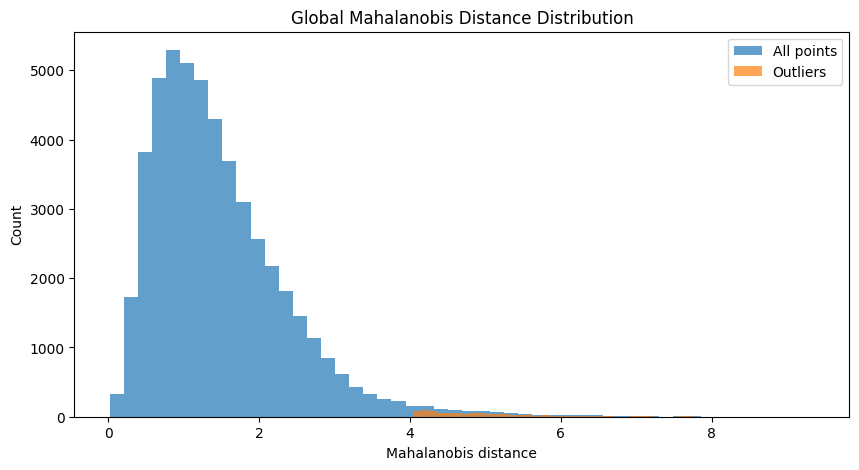

Using Mahalanobis distance threshold: 3.058


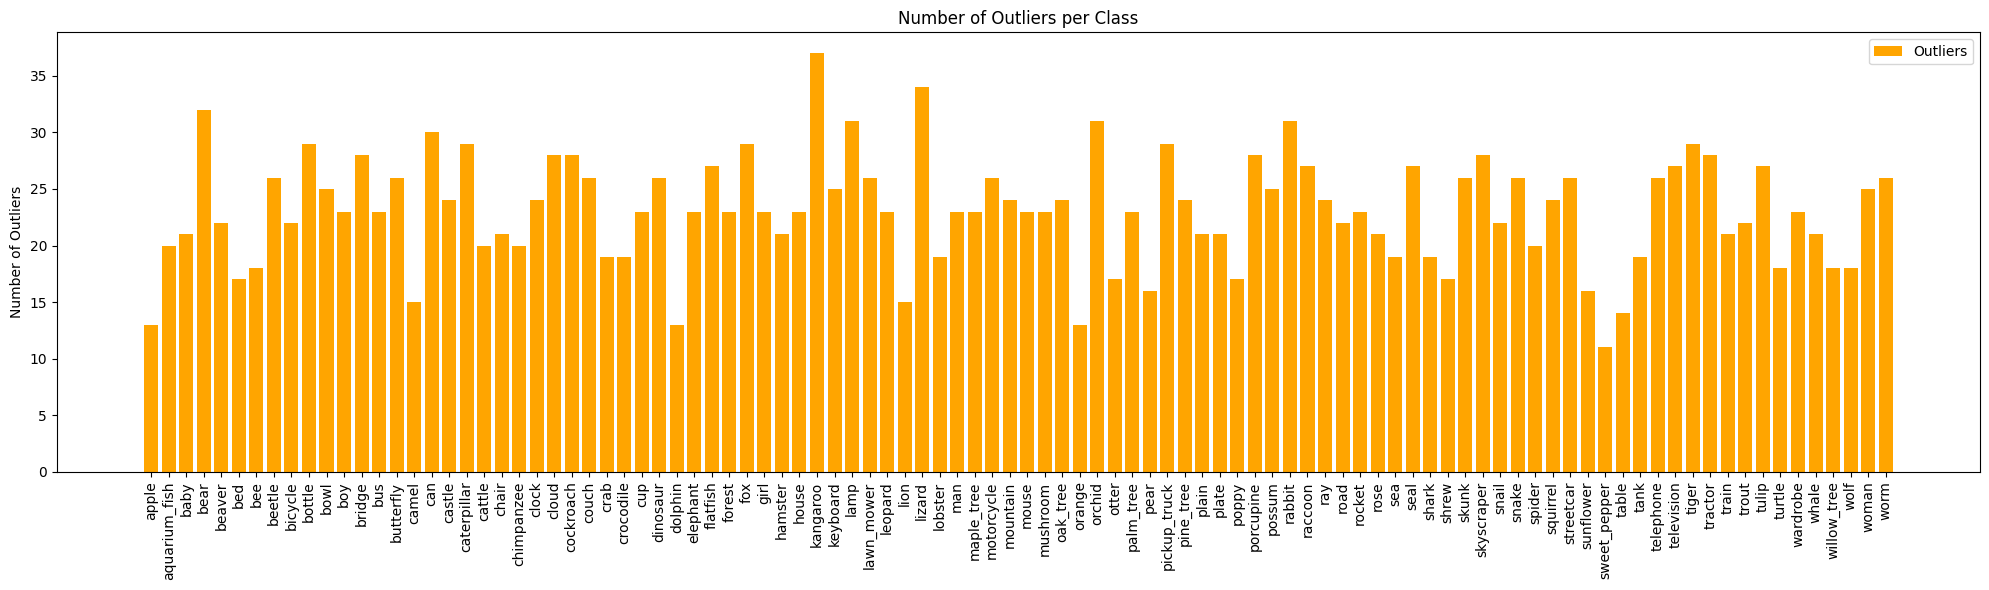

In [ ]:
""" OUTLIER DETECTION: """


def compute_means_per_image(dataset):
    """
    Compute mean intensity per channel (R,G,B) for each image in the dataset.
    """
    means = []
    labels = []
    for img, label in dataset:
        # img shape: [3, H, W]
        mean_per_channel = img.mean(dim=[1, 2]).numpy()
        means.append(mean_per_channel)
        labels.append(label)
    return np.array(means), np.array(labels)





def mahalanobis_outliers(data, threshold=3.0):
    """
    Compute Mahalanobis distance for each point in data (shape: [N, features]).
    Returns boolean array of outlier flags and distances.
    """
    mean_vec = np.mean(data, axis=0)
    cov_mat = np.cov(data, rowvar=False)

    # Use pseudo-inverse for numerical stability
    inv_covmat = np.linalg.pinv(cov_mat)

    dists = np.array([mahalanobis(x, mean_vec, inv_covmat) for x in data])

    # Outlier if distance > threshold
    outliers = dists > threshold
    return outliers, dists





def plot_outlier_distribution(dists, outliers, title="Mahalanobis Distance Distribution"):
    """
    Plot histogram of distances with outliers highlighted.
    """
    plt.figure(figsize=(10, 5))
    plt.hist(dists, bins=50, alpha=0.7, label='All points')
    plt.hist(dists[outliers], bins=50, alpha=0.7, label='Outliers')
    plt.title(title)
    plt.xlabel("Mahalanobis distance")
    plt.ylabel("Count")
    plt.legend()
    plt.show()





def analyze_outliers_global(dataset, threshold=3.0):
    """
    Analyze outliers globally over entire dataset.
    """
    means, labels = compute_means_per_image(dataset)
    outliers, dists = mahalanobis_outliers(means, threshold)
    print(f"Global Outlier Detection:")
    print(f"Total samples: {len(means)}")
    print(f"Number of outliers detected: {np.sum(outliers)} ({np.sum(outliers)/len(means)*100:.2f}%)")
    plot_outlier_distribution(dists, outliers, title="Global Mahalanobis Distance Distribution")
    return outliers, dists





def analyze_outliers_per_class(dataset, threshold=3.0, class_names=None):
    """
    Analyze outliers separately for each class.
    """
    means, labels = compute_means_per_image(dataset)
    unique_classes = np.unique(labels)

    results = defaultdict(dict)

    classes = []
    outlier_counts = []

    for cls in unique_classes:
        class_means = means[labels == cls]
        outliers, dists = mahalanobis_outliers(class_means, threshold)
        cls_name = class_names[cls] if class_names else str(cls)

        results[cls]['outliers'] = outliers
        results[cls]['dists'] = dists
        results[cls]['num_outliers'] = np.sum(outliers)
        results[cls]['total'] = len(class_means)

        classes.append(cls_name)
        outlier_counts.append(np.sum(outliers))

        #print(f"Class {cls} ({cls_name}): {np.sum(outliers)} outliers / {len(class_means)} samples " +
        #      f"({np.sum(outliers)/len(class_means)*100:.2f}%)")

    # Plot bar chart of outliers only
    x = np.arange(len(classes))
    plt.figure(figsize=(20, 6))
    plt.bar(x, outlier_counts, color='orange', label='Outliers')
    plt.xticks(x, classes, rotation=90)
    plt.ylabel('Number of Outliers')
    plt.title('Number of Outliers per Class')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return results




# Setting a threshold based on data dimension and desired confidence level
df = 3  # number of channels (RGB)
confidence = 0.999      # desired confidence level
thr = np.sqrt(chi2.ppf(confidence, df=df))
print(f"Using Mahalanobis distance threshold: {thr:.3f}")

# Global outlier analysis on training set
global_outliers, global_dists = analyze_outliers_global(tot_train_data, threshold=thr)


df = 3  # number of channels (RGB)
confidence = 0.975      # desired confidence level (higher for single class)
thr = np.sqrt(chi2.ppf(confidence, df=df))
print(f"Using Mahalanobis distance threshold: {thr:.3f}")
# Per-class outlier analysis on training set
results_per_class = analyze_outliers_per_class(tot_train_data, threshold=thr, class_names=tot_train_data.classes)


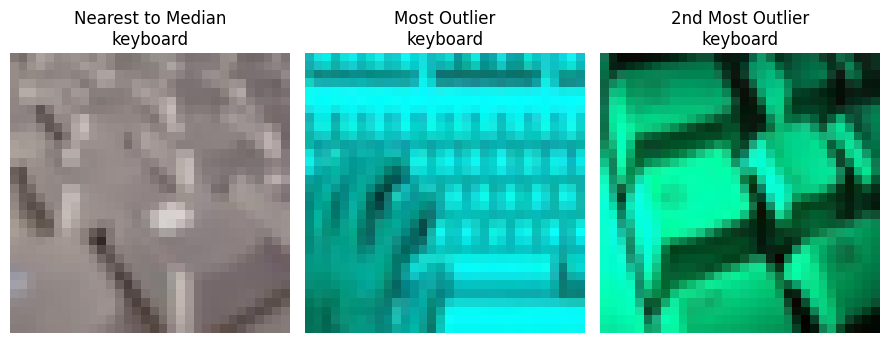

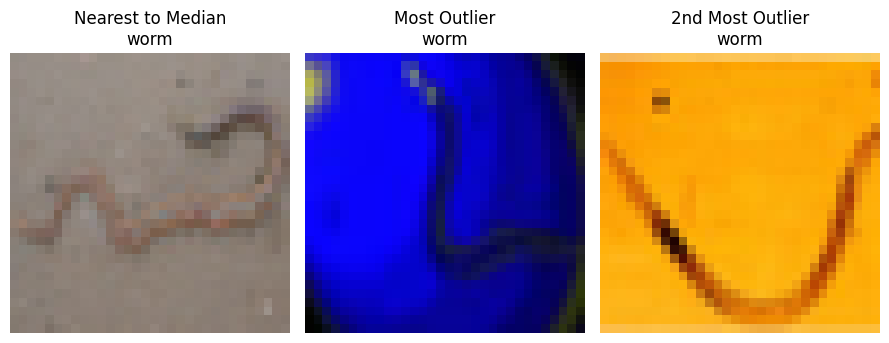

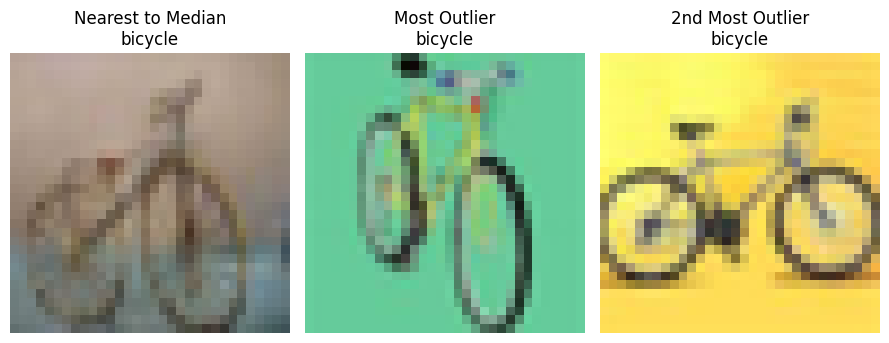

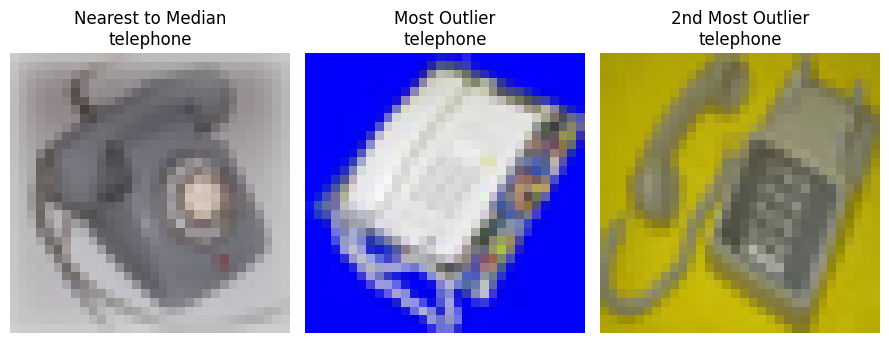

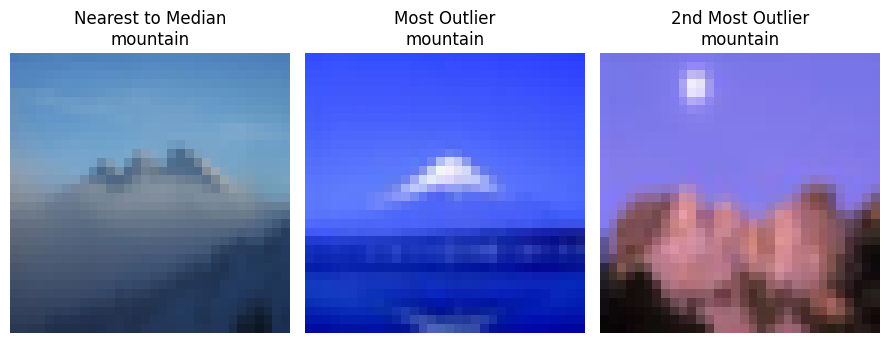

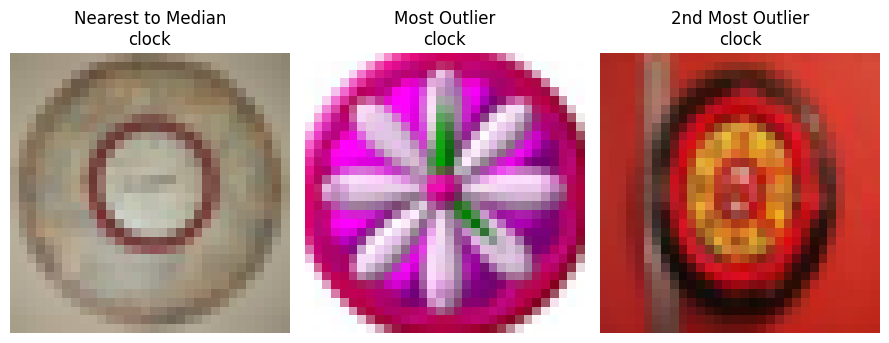

In [ ]:
""" VISUALIZATION of most MEDIAN image and TWO OUTLIER images """

def plot_median_and_outliers(dataset, class_name, results_per_class, title_prefix=""):
    """
    Plot the nearest-to-median image and the top two outliers for a given class
    """
    try:
        class_idx = dataset.classes.index(class_name)
    except ValueError:
        print(f"Class name '{class_name}' not found.")
        return

    data = results_per_class.get(class_idx)
    if data is None:
        print(f"No outlier data for class '{class_name}'.")
        return

    dists = np.array(data['dists'])
    outliers = data['outliers']

    # Get all indices for the class
    indices_in_class = [i for i, (_, label) in enumerate(dataset) if label == class_idx]
    class_images = [dataset[i][0] for i in indices_in_class]

    # Compute synthetic median image
    median_image = torch.median(torch.stack(class_images).float(), dim=0)[0]

    # Find real image closest to the median
    distances_to_median = [torch.norm(img.float() - median_image).item() for img in class_images]
    nearest_pos = np.argmin(distances_to_median)
    nearest_idx = indices_in_class[nearest_pos]
    nearest_image = dataset[nearest_idx][0]

    # Find top 2 outlier positions
    top2_outlier_positions = np.argsort(dists)[-2:][::-1]  # largest two distances
    outlier_images = [dataset[indices_in_class[pos]][0] for pos in top2_outlier_positions]

    # Convert for plotting
    nearest_image_np = nearest_image.permute(1, 2, 0).numpy()
    outlier_images_np = [img.permute(1, 2, 0).numpy() for img in outlier_images]

    # Plot
    fig, axs = plt.subplots(1, 3, figsize=(9, 4))
    axs[0].imshow(nearest_image_np)
    axs[0].set_title(f"{title_prefix}Nearest to Median\n{class_name}")
    axs[0].axis('off')

    axs[1].imshow(outlier_images_np[0])
    axs[1].set_title(f"{title_prefix}Most Outlier\n{class_name}")
    axs[1].axis('off')

    axs[2].imshow(outlier_images_np[1])
    axs[2].set_title(f"{title_prefix}2nd Most Outlier\n{class_name}")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()



plot_median_and_outliers(tot_train_data, "keyboard", results_per_class)
plot_median_and_outliers(tot_train_data, "worm", results_per_class)
plot_median_and_outliers(tot_train_data, "bicycle", results_per_class)
plot_median_and_outliers(tot_train_data, "telephone", results_per_class)
plot_median_and_outliers(tot_train_data, "mountain", results_per_class)
plot_median_and_outliers(tot_train_data, "clock", results_per_class)